In [416]:
# Bot check

# HW_ID: ds_ml6
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: not final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

## Применение реализованных модулей (60 баллов)
Для начала определим путь до ноутбука с реализованными модулями.

In [417]:
# Путь к папке с заданием
path_to_dir: str = ""
# Путь к файлу с модулями
path_to_modules_notebook = path_to_dir + "1_modules.ipynb"

In [418]:
# В Google Colab подключаемся к диску
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')
    path_to_modules_notebook = "drive/MyDrive/" + path_to_modules_notebook

Следующая ячейка делает `from 1_modules.ipynb import *`, таким образом позволяя этому ноутбуку видеть все модули.

In [419]:
%run $path_to_modules_notebook

test_LeakyReLU (__main__.TestLayers.test_LeakyReLU) ... ok
test_Linear (__main__.TestLayers.test_Linear) ... 

ok
test_LogSoftMax (__main__.TestLayers.test_LogSoftMax) ... ok
test_NLLCriterion (__main__.TestLayers.test_NLLCriterion) ... ok
test_ReLU (__main__.TestLayers.test_ReLU) ... ok
test_Sequential (__main__.TestLayers.test_Sequential) ... /home/alexander/.local/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
ok
test_SoftMax (__main__.TestLayers.test_SoftMax) ... ok

----------------------------------------------------------------------
Ran 7 tests in 4.454s

OK


После того, как все слои в `1_modules.ipynb` протестированы и работают корректно, проверим нейросеть на наборах синтетических данных.

In [420]:
import numpy as np
from sklearn import datasets

import seaborn as sns
from IPython import display
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import torch
import torch.nn as nn
from torch.optim import SGD as torch_sgd

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF3300', '#00CC66'])
RANDOM_SEED = 42

sns.set(font_scale=1, palette='Set2')
np.random.seed(RANDOM_SEED)

Будем применять реализованные модули на синтетических данных.

### 1. Линейно разделимая выборка (35 баллов)

Обучим однослойную нейронную сеть решать линейно-разделимую классификацию на 2 класса.

In [421]:
n_samples = 1024
n_classes = 2

varied_blobs = datasets.make_blobs(
    n_samples=n_samples,
    n_features=2,
    centers=n_classes,
    cluster_std=[1.0, 2.5],
    random_state=RANDOM_SEED
)

sample, labels = varied_blobs

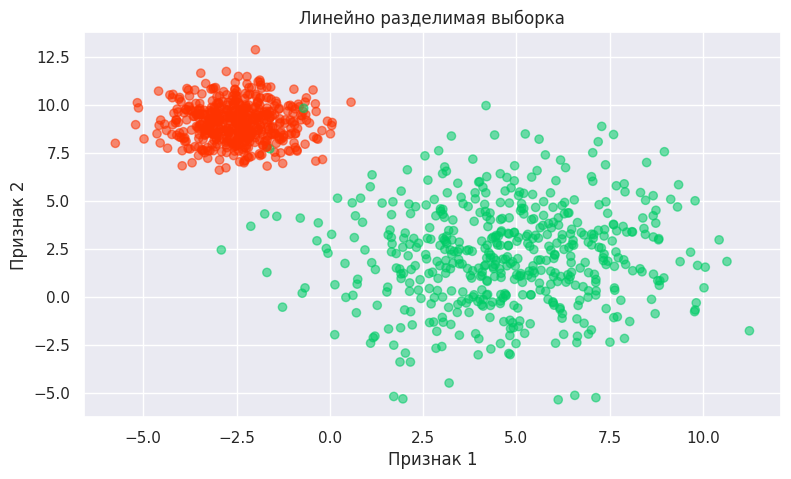

In [422]:
plt.figure(figsize=(9, 5))
plt.title('Линейно разделимая выборка')
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.scatter(sample[:, 0], sample[:, 1], c=labels, cmap=cm_bright, alpha=0.55)

Генератор батчей. Помним, что нейросети обучаются итеративно $-$ по батчам.

In [423]:
def train_generator(sample, labels, batch_size):
    '''
    Генератор батчей.
    На каждом шаге возвращает `batch_size` объектов из `sample` и их
    меток из `labels`.
    '''
    n_samples = sample.shape[0]
    # Перемешиваем в случайном порядке в начале эпохи
    indices = np.arange(n_samples)
    np.random.shuffle(indices)

    # Обратите внимание на yield вместо return
    # (если раньше не сталкивались с генераторами)
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        batch_idx = indices[start:end]
        yield sample[batch_idx], labels[batch_idx]

Функция для удобного обучения модели.

In [424]:
def train_model(
    model,
    sample, y,
    criterion,
    opt_params,
    n_epoch,
    batch_size
):
    '''
    Обучает модель из вашего мини-фреймворка.
    Возвращает обученную модель, историю значений функции потерь
    и метрики качества.

    :param `model`: модель из вашего мини-фреймворка
    :param `sample`: матрица объектов
    :param `y`: вектор истинных меток объектов
    :param `criterion`: функция потерь
    :param `opt_params`: гиперпараметры оптимизатора
    :param `n_epoch`: количество эпох
    :param `batch_size`: размер одного батча
    '''

    loss_history = []

    for i in range(n_epoch):
        for x_batch, y_batch in train_generator(sample, y, batch_size):
            # Обнуляем градиенты с предыдущей итерации
            # Forward pass
            # Backward pass

            model.zero_grad_params()
            logits = model.forward(x_batch)
            loss = criterion.forward(logits, y_batch)

            model.backward(x_batch, criterion.backward(logits, y_batch))

            # Обновление весов
            SGD(model.get_parameters(),
                model.get_grad_params(),
                opt_params)
            loss_history.append(loss)

        display.clear_output(wait=True)

        plt.figure(figsize=(6, 4))
        plt.title("Функция потерь на train")
        plt.xlabel("итерация")
        plt.ylabel("лосс")
        plt.plot(loss_history, 'b', label=f'lr={opt_params["learning_rate"]}')
        plt.title(f'Loss: {loss:.3f}')
        plt.legend()
        plt.show()

    return model, loss_history

Построим однослойную нейросеть для классификации: размер слоя $2 \times 2$, так как 2 признака и 2 класса. В качестве последнего слоя рекомендуется использовать `LogSoftMax`.

In [425]:
net = Sequential()
net.add(Linear(2, 2))
net.add(ReLU())
net.add(LogSoftMax())

print(net)

Linear 2 -> 2
ReLU
LogSoftMax



Объявим оптимизируемую функцию потерь и гиперпараметры.

In [426]:
# Функция потерь
criterion = NLLCriterion()

# Гиперпараметры оптимизатора
optimizer_config = {'learning_rate' : 1e-2}

# Гиперпараметры цикла обучения и генератора
n_epoch = 50
batch_size = 128

Проверим, что кодирование производится верно.

In [427]:
y = np.hstack([1 - labels[:, None], labels[:, None]])
print(y.shape)
print(labels[:10])
print(y[:10])

(1024, 2)
[0 1 1 0 1 1 1 1 1 0]
[[1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]]


Обучим модель с помощью функции `train_model`.

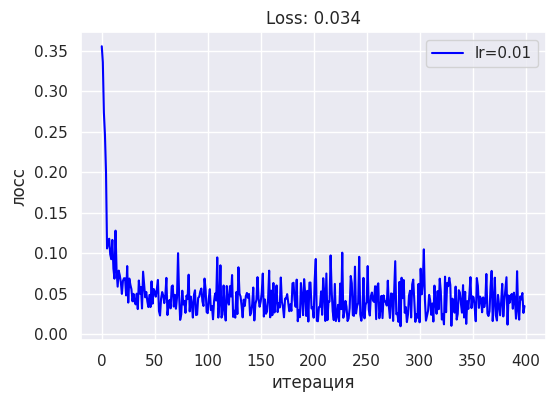

In [428]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

net, loss_history = train_model(
    net,
    sample, y,
    criterion,
    optimizer_config,
    n_epoch,
    batch_size
)

Поменяйте гиперпараметр `learning_rate` в `optimizer_config` на `1e-1`, `1e-2`, `1e-3` и `1e-4`.

Как это влияет на обучение?

In [429]:
def set_lr_experiment(lr):
    '''Запускает тот же эксперимент с данным lr'''
    net = Sequential()
    net.add(Linear(2, 2))
    net.add(LogSoftMax())

    optimizer_config = {'learning_rate' : lr}

    net, loss_history = train_model(
        net,
        sample, y,
        criterion,
        optimizer_config,
        n_epoch,
        batch_size
    )

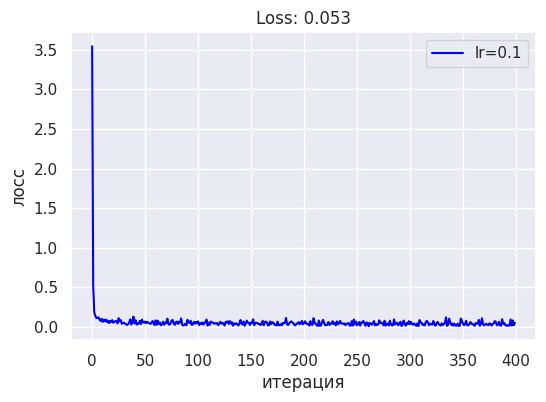

In [430]:
set_lr_experiment(1e-1)


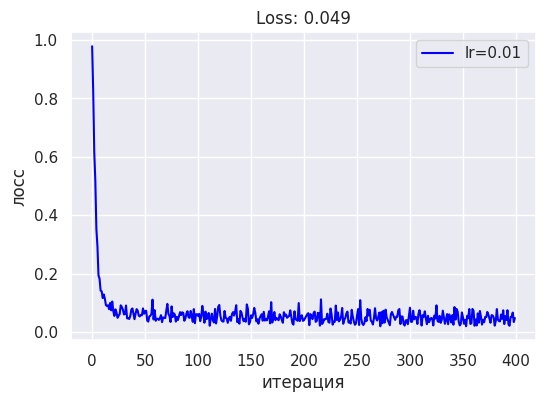

In [431]:
set_lr_experiment(1e-2)

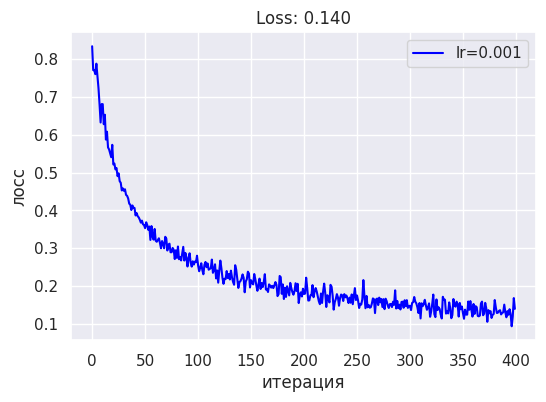

In [432]:
set_lr_experiment(1e-3)

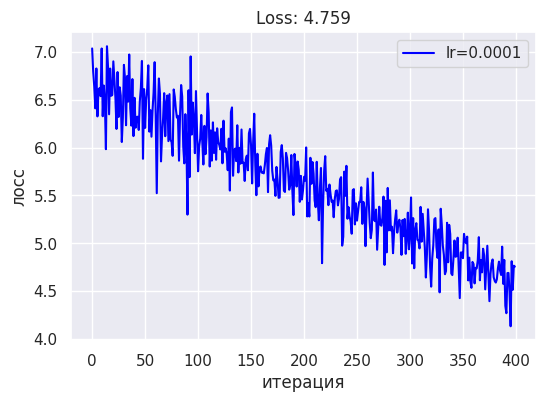

In [433]:
set_lr_experiment(1e-4)

**Вывод**

Как видим, при большом lr модель обучается меньше итераций, чем при малом. Но при больших lr можно пропустить какие-то тонкости в данных, в то время как малый lr затягивает обучение.

Батч-генератор для тестовой выборки.

In [434]:
def generate_grid(sample, h=0.02):
    '''
    Генерирует двумерную сетку,
    возвращает 2 сетки - координаты x и координаты y
    '''
    x_min, x_max = sample[:, 0].min() - .5, sample[:, 0].max() + .5
    y_min, y_max = sample[:, 1].min() - .5, sample[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy


def test_generator(sample):
    '''
    Батч-генератор для тестовых данных (без меток).
    '''
    n_samples = sample.shape[0]
    indices = np.arange(n_samples)
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        batch_idx = indices[start:end]
        yield sample[batch_idx]

Функции для удобного тестирования модели.

In [435]:
def test_model(model, test_sample):
    '''
    Тестирует модель на тестовой выборке.
    '''
    preds = []
    for test_batch in test_generator(test_sample):
        batch = model.forward(test_batch)
        batch = batch.argmax(axis=1).reshape(-1,1)
        preds.append(batch)
    preds = np.vstack(preds)
    return preds


def plot_grid_preds(sample, labels, xx, yy, preds, title):
    '''
    Функция для удобной отрисовки предсказаний нейросети на двумерной сетке.
    '''
    plt.figure(figsize=(8, 5))
    plt.title(title)
    plt.xlabel('Признак 1')
    plt.ylabel('Признак 2')
    plt.scatter(sample[:, 0], sample[:, 1], c=labels, cmap=cm_bright, alpha=0.55)
    plt.contourf(xx, yy, preds, alpha=.2, cmap=cm)
    plt.show();

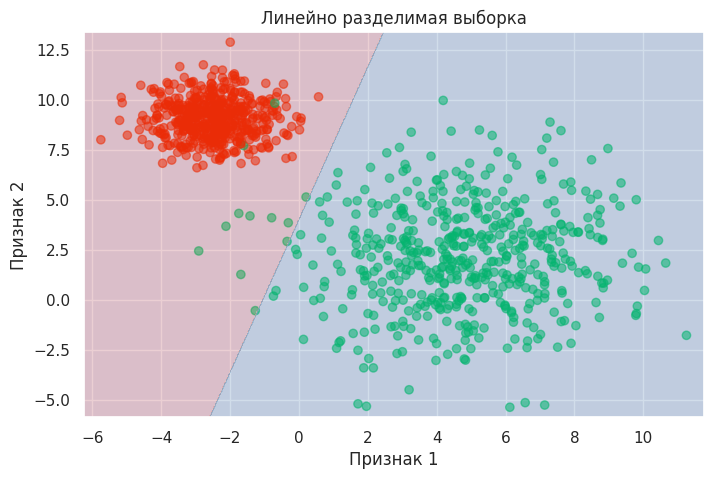

In [436]:
xx, yy = generate_grid(sample)
# получим набор точек с 2 координатами
test_sample = np.c_[xx.ravel(), yy.ravel()]

test_predictions = test_model(net, test_sample)
test_predictions = test_predictions.reshape(xx.shape)

plot_grid_preds(
    sample,
    labels,
    xx, yy,
    test_predictions,
    'Линейно разделимая выборка'
)

Сравним с точно такой же моделью, но на PyTorch.

*Подсказка.* Названия слоев идентичны, если брать их из `torch.nn`. Отличия только в оптимизаторе и названии функции потерь.

In [437]:
net_torch = nn.Sequential(
    nn.Linear(2, 2),
    nn.LogSoftmax(dim=1)
)

print(net_torch)

Sequential(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): LogSoftmax(dim=1)
)


In [438]:
def train_model_torch(
    model,
    sample, y,
    criterion,
    optimizer,
    n_epoch,
    batch_size
):
    '''
    Обучает модель из PyTorch.
    Возвращает обученную модель, историю значений функции потерь
    и метрики качества.

    :param `model`: модель из PyTorch
    :param `sample`: матрица объектов
    :param `y`: вектор истинных меток объектов
    :param `criterion`: функция потерь
    :param `opt_params`: гиперпараметры оптимизатора
    :param `n_epoch`: количество эпох
    :param `batch_size`: размер одного батча
    '''

    loss_history = []

    for i in range(n_epoch):
        for x_batch, y_batch in train_generator(sample, y, batch_size):
            # Обнуляем градиенты с предыдущей итерации
            # Forward pass
            # Backward pass
            # Обновление весов
            
            # Преобразование batch данных в тензоры
            x_batch = torch.FloatTensor(x_batch)
            y_batch = torch.LongTensor(y_batch).argmax(dim=1)

            # Обнуляем градиенты с предыдущей итерации
            optimizer.zero_grad()
            
            # Forward pass
            logits = model(x_batch)
            loss = criterion(logits, y_batch)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Добавляем текущее значение потерь в историю
            loss_history.append(loss.item())

        display.clear_output(wait=True)

        plt.figure(figsize=(6, 5))
        plt.title("Функция потерь на train, loss")
        plt.xlabel("итерация")
        plt.ylabel("лосс")
        plt.plot(loss_history, 'b')
        plt.show()
        print('Current loss: %f' % loss)

    return model, loss_history

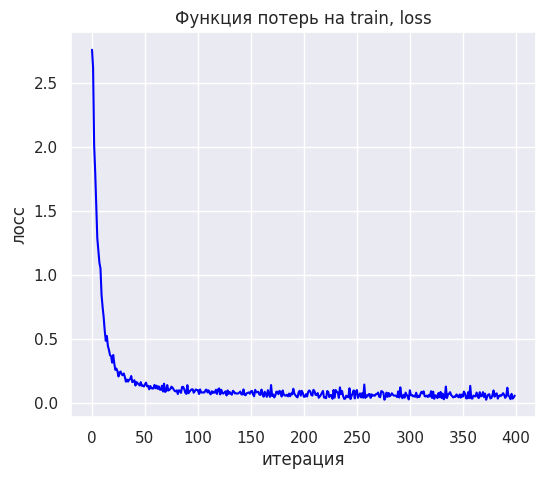

Current loss: 0.056653


In [439]:
criterion = nn.NLLLoss()
optimizer = torch_sgd(net_torch.parameters(), lr=1e-2)

net_torch, loss_history = train_model_torch(
    net_torch, sample, y,
    criterion,
    optimizer,
    n_epoch,
    batch_size
)

*Для самопроверки.* Значение функции потерь (лосса) должны быть примерно одинаковые у вашей модели и у сети из PyTorch. Каким именно на этом датасете $-$ см таблицу ниже.

|  Архитектура  | learning_rate | Значение лосса |
|-------------|---------------|-------------|
| Linear(2,2) |  1e-2         | 0.1 и ниже |

Как видим наш loss $< 0.1$, что соответcтвует таблице.

In [440]:
def test_torch(model, test_sample):
    '''
    Тестирует модель из PyTorch на тестовой выборке.
    '''
    preds = []
    with torch.no_grad():
        for test_batch in test_generator(test_sample):
            preds_batch = model(torch.FloatTensor(test_batch))
            preds_batch = preds_batch.argmax(axis=1).reshape(-1,1)
            preds.append(preds_batch.detach().numpy())
    preds = np.vstack(preds)
    return preds

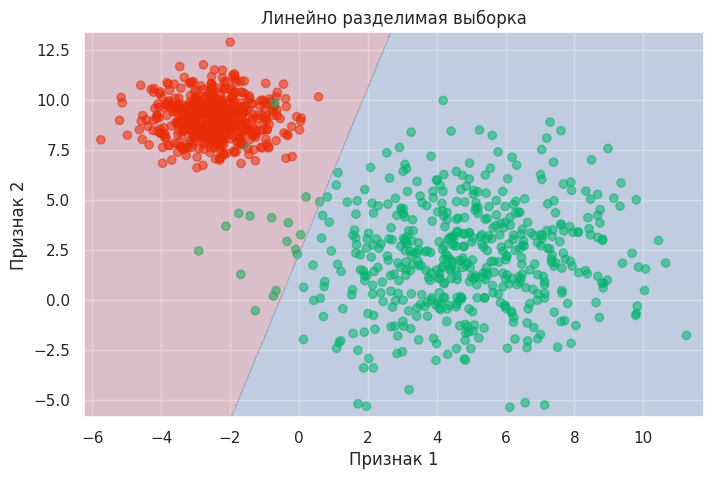

In [441]:
xx, yy = generate_grid(sample)
# получим набор точек с 2 координатами
test_sample = np.c_[xx.ravel(), yy.ravel()]

test_predictions = test_torch(net_torch, test_sample)
test_predictions = test_predictions.reshape(xx.shape)

plot_grid_preds(
    sample,
    labels,
    xx, yy,
    test_predictions,
    'Линейно разделимая выборка'
)

Рисунки с предсказаниями должны практически совпадать у вашей модели и у модели на PyTorch.

Как видим, рисунки почти совпадают.

### 2. Вложенные окружности (30 баллов)

Проверим работу нейросети на более сложной выборке, которая линейно не разделима в исходном пространстве признаков.

In [442]:
n_samples = 1024

noisy_circles = datasets.make_circles(
    n_samples=n_samples,
    factor=.5,
    noise=.05
)

sample, labels = noisy_circles

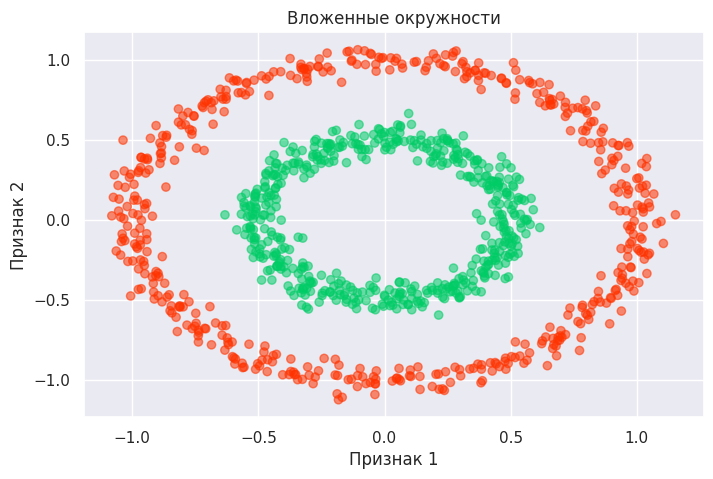

In [443]:
plt.figure(figsize=(8, 5))
plt.title('Вложенные окружности')
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.scatter(sample[:,0], sample[:,1], c=labels, cmap=cm_bright, alpha=0.55);

Сначала попробуем обучить и протестировать однослойную нейросеть:

In [444]:
net = Sequential()
net.add(Linear(2, 2))
net.add(ReLU())
net.add(LogSoftMax())
print(net)

# Функция потерь
criterion = NLLCriterion()

# Гиперпараметры оптимизатора
optimizer_config = {'learning_rate' : 1e-2, 'momentum': 0.9}

# Гиперпараметры цикла обучения и генератора
n_epoch = 50
batch_size = 128

Linear 2 -> 2
ReLU
LogSoftMax



In [445]:
y = np.hstack([1 - labels[:, None], labels[:, None]])
print(y.shape)
print(labels[:10])
print(y[:10])

(1024, 2)
[1 1 1 1 0 1 0 0 0 1]
[[0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]]


Обучим и визуализируем предсказания:

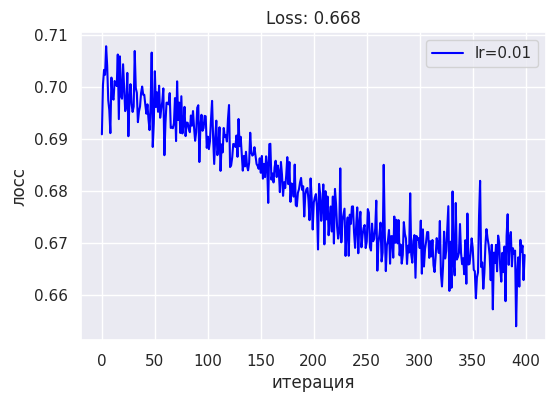

In [446]:
net, loss_history = train_model(
    net,
    sample, y,
    criterion,
    optimizer_config,
    n_epoch,
    batch_size
)

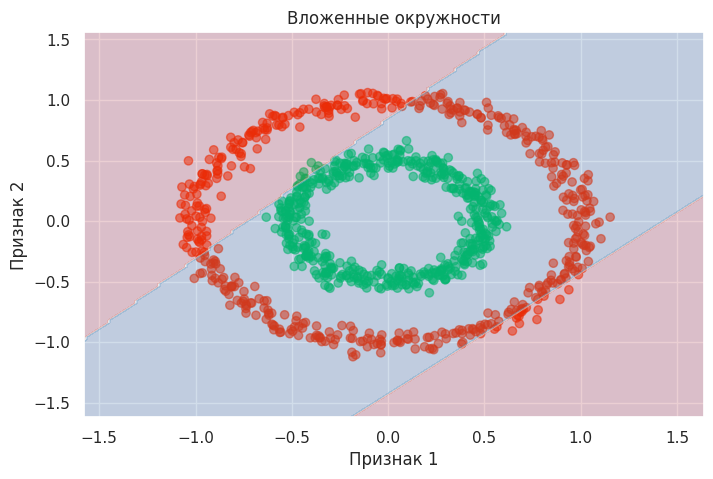

In [447]:
xx, yy = generate_grid(sample)
test_sample = np.c_[xx.ravel(), yy.ravel()]

test_predictions = test_model(net, test_sample)
test_predictions = test_predictions.reshape(xx.shape)

plot_grid_preds(sample, labels, xx, yy,
                test_predictions, 'Вложенные окружности')

Вряд ли у вас получился лосс ниже 0.68 и адекватный рисунок. Это говорит о том, что один слой не может решить задачу.

Попробуем сделать **двухслойную** нейросеть. Не жалейте нейронов в скрытый слой. Окружности должны хорошо отделяться начиная с 30-40 нейронов.

*Подсказка.* Не забудьте про нелинейности.

In [448]:
net = Sequential()
net.add(Linear(2, 100))
net.add(ReLU())
net.add(Linear(100, 2))
net.add(LogSoftMax())
print(net)

criterion = NLLCriterion()


optimizer_config = {'learning_rate' : 1e-2}

n_epoch = 100
batch_size = 128

y = np.hstack([1 - labels[:, None], labels[:, None]])
print(y.shape)

Linear 2 -> 100
ReLU
Linear 100 -> 2
LogSoftMax

(1024, 2)


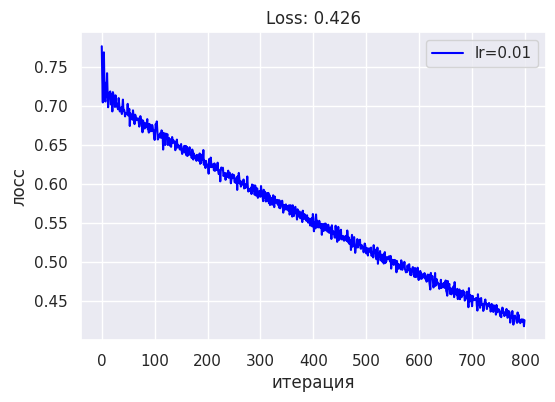

In [449]:
net, loss_history = train_model(
    net,
    sample, y,
    criterion,
    optimizer_config,
    n_epoch,
    batch_size
)

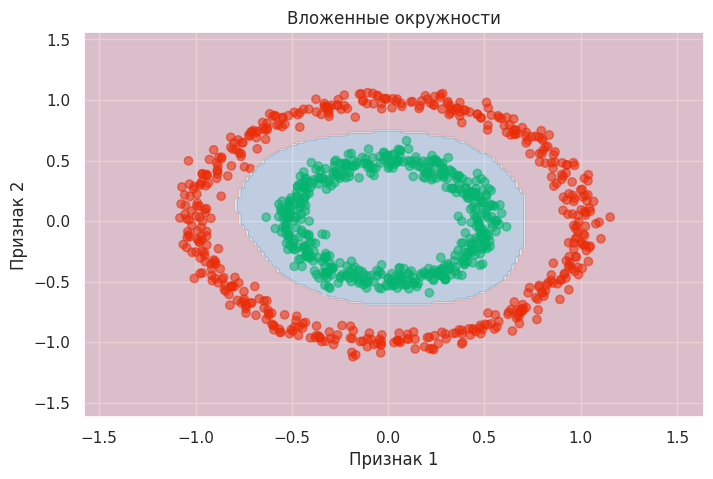

In [450]:
xx, yy = generate_grid(sample)
test_sample = np.c_[xx.ravel(), yy.ravel()]

test_predictions = test_model(net, test_sample)
test_predictions = test_predictions.reshape(xx.shape)

plot_grid_preds(sample, labels, xx, yy, test_predictions, "Вложенные окружности")

И снова сравним с PyTorch.

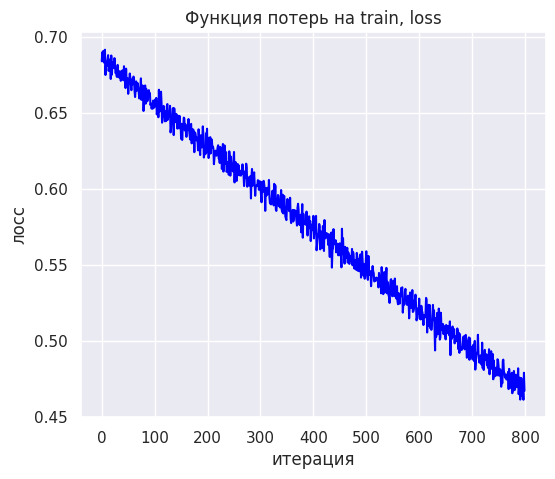

Current loss: 0.467105


In [451]:
net_torch = nn.Sequential(
    nn.Linear(2, 100),
    nn.ReLU(),
    nn.Linear(100, 2),
    nn.LogSoftmax(dim=1)
)

print(net_torch)

criterion = nn.NLLLoss()
optimizer = torch_sgd(net_torch.parameters(), lr=1e-2)

net_torch, loss_history = train_model_torch(
    net_torch, sample, y,
    criterion,
    optimizer,
    n_epoch,
    batch_size
)

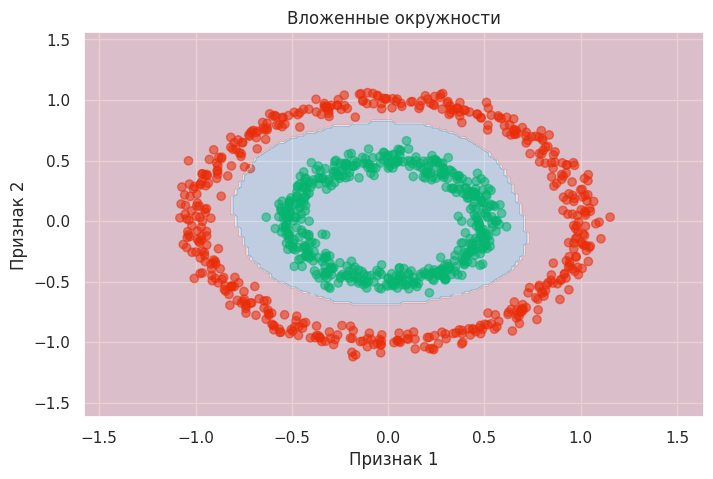

In [452]:
xx, yy = generate_grid(sample)
test_sample = np.c_[xx.ravel(), yy.ravel()]

test_predictions = test_torch(net_torch, test_sample)
test_predictions = test_predictions.reshape(xx.shape)

plot_grid_preds(sample, labels, xx, yy, test_predictions, "Вложенные окружности")

*Для самопроверки*. Значение функции потерь (лосса) должны быть примерно одинаковые у вашей модели и у сети из PyTorch. Каким именно на этом датасете $-$ см. таблицу ниже.

|  Архитектура  | learning_rate | Значение лосса |
|-------------|---------------|-------------|
| (2,100) -> ReLU -> (100,2) |  1e-2         | 0.5 и ниже |

Оба рисунка должны примерно совпадать и адекватно разделять окружности между собой (одна область должна быть "внутри" другой).

Как видим, наша модель имеет лосс ниже указанного, и полученный график примерно совпадает с графиком модели на основе torch.

### 3. Заключение (5 баллов)

Сделайте выводы по проведенным экспериментам.

**Выводы.** 
* Увидели, что линейно разделимые данные можно хорошо отделить нейроной сетью с одним слоем.

* Увидели, что не линейно разделимые данные разделить одним слоем проблематично, но благодаря теореме Цыбенко мы смогли их разделить используя нейросеть лишь с двумя слоями.

* Заметим, увеличение нейронов дает прирост к скорости обучения.

* Также мы убедились, что наша модель работает сравнимо с моделью, основаннй на torch, что может говорить о верной реализации.

### Полезные ссылки

- [Заметки главы ИИ в Tesla Andrej Karpathy по обучению нейросетей](http://karpathy.github.io/2019/04/25/recipe/)
- [Backpropagation на brilliant.org](https://brilliant.org/wiki/backpropagation/)
- См. ссылки в `1_modules.ipynb`